In [17]:
using GraphViz

using StockFlow
using StockFlow.Syntax
using StockFlow.Syntax.Composition
using StockFlow.Syntax.Rewrite

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

This model is re-created based on Garnett's paper:
https://journals.lww.com/stdjournal/Fulltext/2000/11000/Epidemiology_and_Control_of_Curable_Sexually.7.aspx

# 1. Define the components of all the sub-models
## 1.1 The births and deaths of Stock X

In [2]:
X = @stock_and_flow begin
    :stocks
    X

    :parameters
    μ

    :dynamic_variables
    v_births = N * μ
    v_deathX = X * μ

    :flows
    CLOUD => f_births(v_births) => X
    X => f_deathX(v_deathX) => CLOUD

    :sums
    N = [X]

end 

StockAndFlowF {S:1, SV:1, LS:1, F:2, I:1, O:1, V:2, LV:1, LSV:1, P:1, LVV:0, LPV:2, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────┐
│ F │ fv │    fname │
├───┼────┼──────────┤
│ 1 │  1 │ f_births │
│ 2 │  2 │ f_deathX │
└───┴────┴──────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
└───┴─────┴────┘
┌───┬──────────┬─────┐
│ V │    vname │ vop │
├───┼──────────┼─────┤
│ 1 │ v_births │   * │
│ 2 │ v_deathX │   * │
└───┴──────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             1 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     μ │
└───┴───────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    1 │    2 │            2 │
└─────┴──────┴──────┴──────────────┘

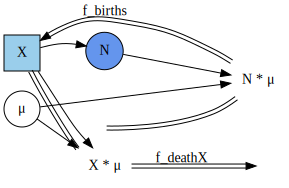

In [3]:
GraphF(X)

## 1.2 The SIS sub-model structure

In [4]:
SIS_A = @stock_and_flow begin

    :stocks
    X
    A

    :parameters
    μ_temp1 
    ϕ_complement
    σ′
    cβ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄_A = v_inf₃ * ϕ_complement

    v_deathA = A * μ_temp1

    :flows
    X => f_newInfectiousA(v_inf₄_A) => A
    A => f_deathA(v_deathA) => CLOUD
    A => f_recoveryA(A * σ′) => X

    :sums
    N = [X, A]
    NI = [A]

end


StockAndFlowF {S:2, SV:2, LS:3, F:3, I:2, O:3, V:6, LV:3, LSV:2, P:4, LVV:3, LPV:4, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     A │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   2 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  4 │ f_newInfectiousA │
│ 2 │  5 │         f_deathA │
│ 3 │  6 │      f_recoveryA │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   3 │  1 │
│ 2 │   1 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  2 │
└───┴─────┴────┘
┌───┬─────────────────────┬─────┐
│ V │               vname │ vop │
├───┼─────────────────────┼─────┤
│ 1 │              v_inf₁ │   * │
│ 2 │              v_inf₂ │   / │
│ 3 │              v_inf₃ │   * │
│ 4 │            v_inf₄_A │   * │
│ 5 │            v_deathA │   * │
│ 6 │ ##v_f_recoveryA#292 │   * │
└───┴─────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   3 │           2 │
│  2 │   2 │   5 │           1 │
│  3 │   2 │   6 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     2 │    1 │             2 │
│   2 │     1 │    2 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────────┐
│ P │        pname │
├───┼──────────────┤
│ 1 │      μ_temp1 │
│ 2 │ ϕ_complement │
│ 3 │           σ′ │
│ 4 │           cβ │
└───┴──────────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             1 │
│   2 │     2 │     3 │             1 │
│   3 │     3 │     4 │             1 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    4 │    1 │            1 │
│   2 │    2 │    4 │            2 │
│   3 │    1 │    5 │            2 │
│   4 │    3 │    6 │            2 │
└─────┴──────┴──────┴──────────────┘

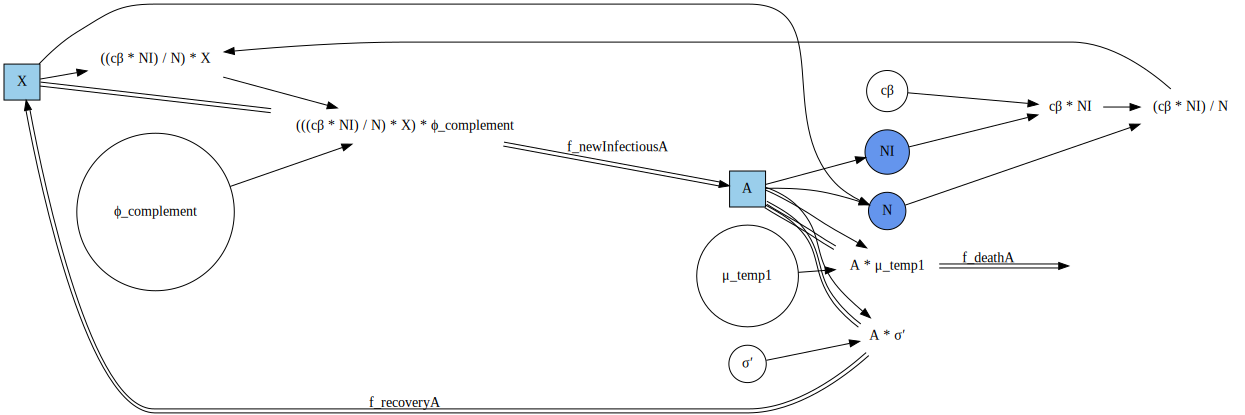

In [5]:
GraphF(SIS_A)

In [6]:
SIS_Y = @stock_and_flow begin
    
    :stocks
    X
    Y

    :parameters
    μ_temp2
    ϕ
    σ
    λ

    :dynamic_variables
    v_inf₄_Y = ϕ * λ 
    
    v_deathY = Y * μ_temp2

    :flows
    X => f_newInfectiousY(v_inf₄_Y) => Y
    Y => f_deathY(v_deathY) => CLOUD
    Y => f_recoveryY(Y * σ) => X

    :sums
    N = [X, Y]
    NI = [Y]

end

StockAndFlowF {S:2, SV:2, LS:3, F:3, I:2, O:3, V:3, LV:2, LSV:0, P:4, LVV:0, LPV:4, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     Y │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   2 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  1 │ f_newInfectiousY │
│ 2 │  2 │         f_deathY │
│ 3 │  3 │      f_recoveryY │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   3 │  1 │
│ 2 │   1 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  2 │
└───┴─────┴────┘
┌───┬─────────────────────┬─────┐
│ V │               vname │ vop │
├───┼─────────────────────┼─────┤
│ 1 │            v_inf₄_Y │   * │
│ 2 │            v_deathY │   * │
│ 3 │ ##v_f_recoveryY#293 │   * │
└───┴─────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   2 │           1 │
│  2 │   2 │   3 │           1 │
└────┴─────┴─────┴─────────────┘
┌───┬─────────┐
│ P │   pname │
├───┼─────────┤
│ 1 │ μ_temp2 │
│ 2 │       ϕ │
│ 3 │       σ │
│ 4 │       λ │
└───┴─────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    2 │    1 │            1 │
│   2 │    4 │    1 │            2 │
│   3 │    1 │    2 │            2 │
│   4 │    3 │    3 │            2 │
└─────┴──────┴──────┴──────────────┘

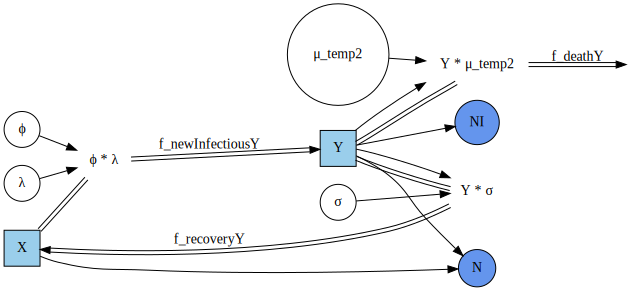

In [7]:
GraphF(SIS_Y)

# 2 Compose
## 2.1 Define composition rule

In [8]:
XAY_model = sfcompose(X, SIS_A, SIS_Y, quote
    (X, A, Y)

    X, A, Y ^ X => N
    A, Y ^ () => NI
end)

StockAndFlowF {S:3, SV:2, LS:5, F:8, I:5, O:7, V:11, LV:6, LSV:3, P:9, LVV:3, LPV:10, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     A │
│ 3 │     Y │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   2 │    2 │
│  4 │   3 │    1 │
│  5 │   3 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  1 │         f_births │
│ 2 │  2 │         f_deathX │
│ 3 │  6 │ f_newInfectiousA │
│ 4 │  7 │         f_deathA │
│ 5 │  8 │      f_recoveryA │
│ 6 │  9 │ f_newInfectiousY │
│ 7 │ 10 │         f_deathY │
│ 8 │ 11 │      f_recoveryY │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   5 │  1 │
│ 3 │   3 │  2 │
│ 4 │   8 │  1 │
│ 5 │   6 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   4 │  2 │
│ 4 │   5 │  2 │
│ 5 │   6 │  1 │
│ 6 │   7 │  3 │
│ 7 │   8 │  3 │
└───┴─────┴────┘
┌────┬─────────────────────┬─────┐
│  V │               vname │ vop │
├────┼─────────────────────┼─────┤
│  1 │            v_births │   * │
│  2 │            v_deathX │   * │
│  3 │              v_inf₁ │   * │
│  4 │              v_inf₂ │   / │
│  5 │              v_inf₃ │   * │
│  6 │            v_inf₄_A │   * │
│  7 │            v_deathA │   * │
│  8 │ ##v_f_recoveryA#292 │   * │
│  9 │            v_inf₄_Y │   * │
│ 10 │            v_deathY │   * │
│ 11 │ ##v_f_recoveryY#293 │   * │
└────┴─────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
│  2 │   1 │   5 │           2 │
│  3 │   2 │   7 │           1 │
│  4 │   2 │   8 │           1 │
│  5 │   3 │  10 │           1 │
│  6 │   3 │  11 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             1 │
│   2 │     2 │    3 │             2 │
│   3 │     1 │    4 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────────┐
│ P │        pname │
├───┼──────────────┤
│ 1 │            μ │
│ 2 │      μ_temp1 │
│ 3 │ ϕ_complement │
│ 4 │           σ′ │
│ 5 │           cβ │
│ 6 │      μ_temp2 │
│ 7 │            ϕ │
│ 8 │            σ │
│ 9 │            λ │
└───┴──────────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     3 │     4 │             1 │
│   2 │     4 │     5 │             1 │
│   3 │     5 │     6 │             1 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    1 │    2 │            2 │
│   3 │    5 │    3 │            1 │
│   4 │    3 │    6 │            2 │
│   5 │    2 │    7 │            2 │
│   6 │    4 │    8 │            2 │
│   7 │    7 │    9 │            1 │
│   8 │    9 │    9 │            2 │
│   9 │    6 │   10 │            2 │
│  10 │    8 │   11 │            2 │
└─────┴──────┴──────┴──────────────┘

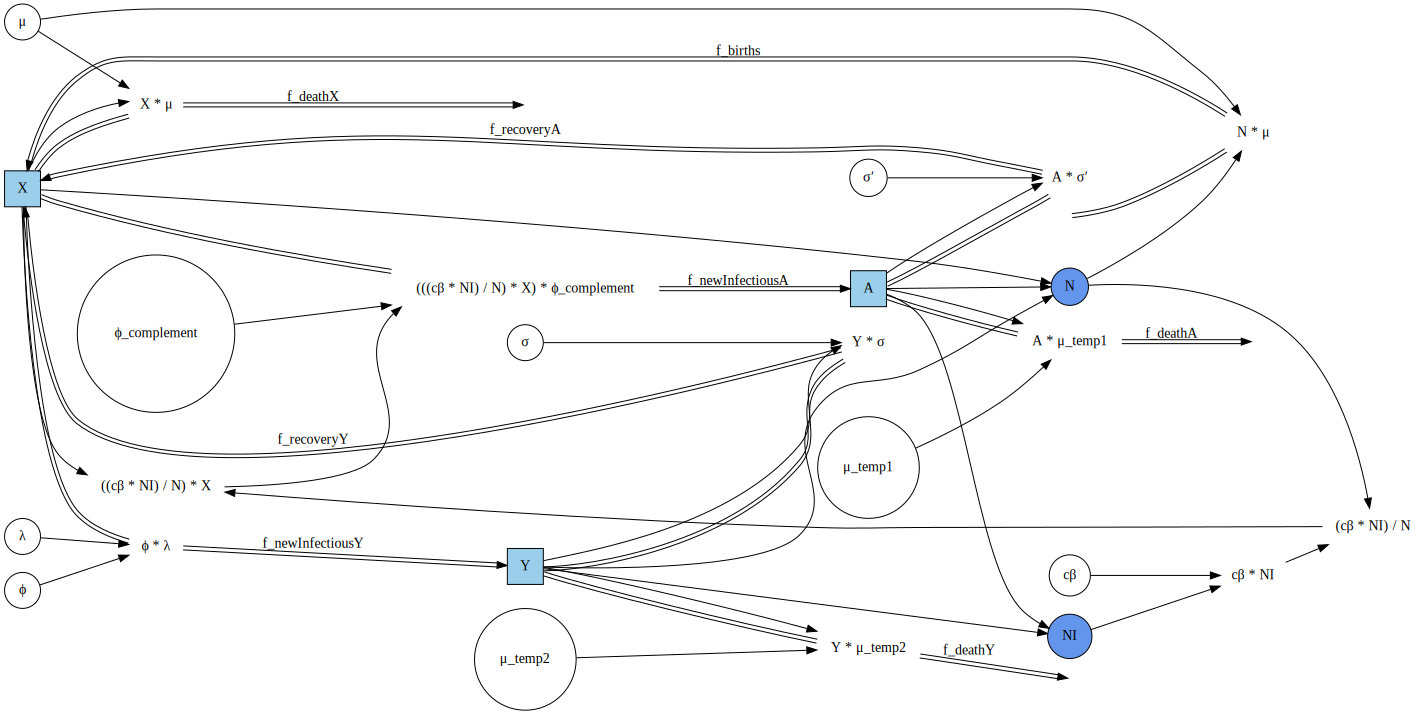

In [9]:
GraphF(XAY_model)

# 3 Rewrite

In [10]:
XAY_model_rewritten = sfrewrite(XAY_model, quote
    :swapping
    v_deathA = A * μ_temp1 => A * μ
    v_deathY = Y * μ_temp2 => Y * μ
    v_inf₄_Y = ϕ * λ => ϕ * v_inf₃

    :parameters
    -μ_temp1
    -μ_temp2
    -λ
end)

StockAndFlowF {S:3, SV:2, LS:5, F:8, I:5, O:7, V:11, LV:6, LSV:3, P:6, LVV:4, LPV:9, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     A │
│ 3 │     Y │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   2 │    2 │
│  4 │   3 │    1 │
│  5 │   3 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  1 │         f_births │
│ 2 │  2 │         f_deathX │
│ 3 │  6 │ f_newInfectiousA │
│ 4 │  7 │         f_deathA │
│ 5 │  8 │      f_recoveryA │
│ 6 │  9 │ f_newInfectiousY │
│ 7 │ 10 │         f_deathY │
│ 8 │ 11 │      f_recoveryY │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   5 │  1 │
│ 3 │   8 │  1 │
│ 4 │   3 │  2 │
│ 5 │   6 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   6 │  1 │
│ 4 │   4 │  2 │
│ 5 │   5 │  2 │
│ 6 │   7 │  3 │
│ 7 │   8 │  3 │
└───┴─────┴────┘
┌────┬─────────────────────┬─────┐
│  V │               vname │ vop │
├────┼─────────────────────┼─────┤
│  1 │            v_births │   * │
│  2 │            v_deathX │   * │
│  3 │              v_inf₁ │   * │
│  4 │              v_inf₂ │   / │
│  5 │              v_inf₃ │   * │
│  6 │            v_inf₄_A │   * │
│  7 │            v_deathA │   * │
│  8 │ ##v_f_recoveryA#292 │   * │
│  9 │            v_inf₄_Y │   * │
│ 10 │            v_deathY │   * │
│ 11 │ ##v_f_recoveryY#293 │   * │
└────┴─────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
│  2 │   1 │   5 │           2 │
│  3 │   2 │   7 │           1 │
│  4 │   2 │   8 │           1 │
│  5 │   3 │  10 │           1 │
│  6 │   3 │  11 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             1 │
│   2 │     2 │    3 │             2 │
│   3 │     1 │    4 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────────┐
│ P │        pname │
├───┼──────────────┤
│ 1 │            μ │
│ 2 │ ϕ_complement │
│ 3 │           σ′ │
│ 4 │           cβ │
│ 5 │            ϕ │
│ 6 │            σ │
└───┴──────────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     3 │     4 │             1 │
│   2 │     4 │     5 │             1 │
│   3 │     5 │     6 │             1 │
│   4 │     5 │     9 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    1 │    2 │            2 │
│   3 │    4 │    3 │            1 │
│   4 │    2 │    6 │            2 │
│   5 │    1 │    7 │            2 │
│   6 │    3 │    8 │            2 │
│   7 │    5 │    9 │            1 │
│   8 │    1 │   10 │            2 │
│   9 │    6 │   11 │            2 │
└─────┴──────┴──────┴──────────────┘

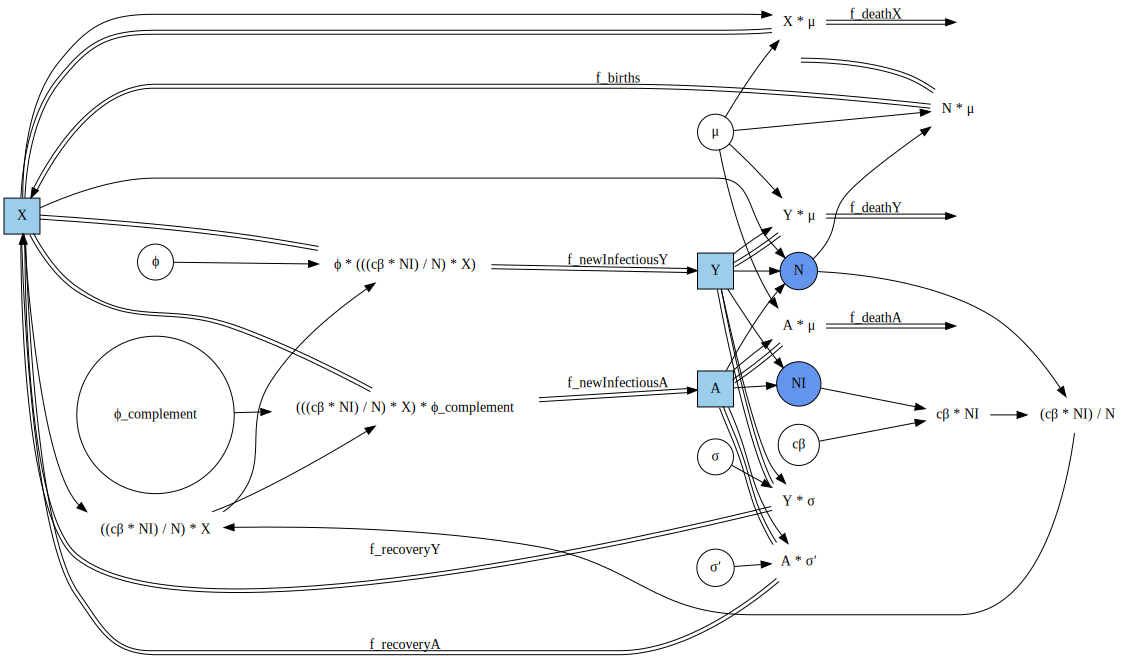

In [11]:
GraphF(XAY_model_rewritten)

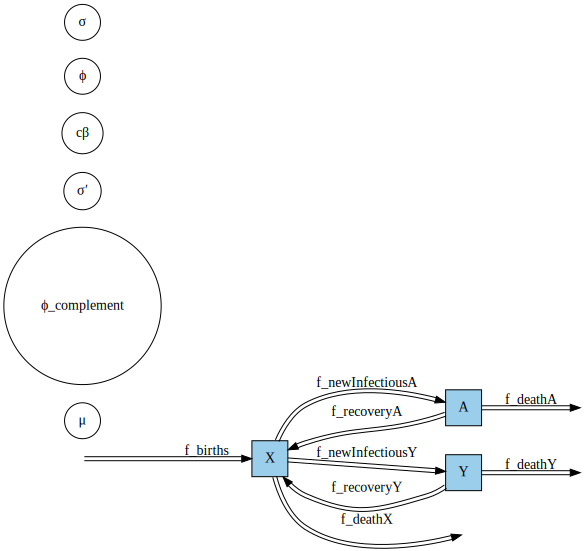

In [12]:
GraphF(XAY_model_rewritten,type="SF")

# 3. Solve ODEs

In [13]:
# define values of constant parameters
# unit: year
p = LVector(
    cβ=15*0.7, μ=1/15,ϕ=(0.95+0.4)/2,σ=12/4,σ′=12/4,ϕ_complement=(1.0 - ((0.95+0.4)/2))
)
# define initial values for stocks
u0 = LVector(
    X=990, A=5, Y=5
)

3-element LArray{Int64, 1, Vector{Int64}, (:X, :A, :Y)}:
 :X => 990
 :A => 5
 :Y => 5

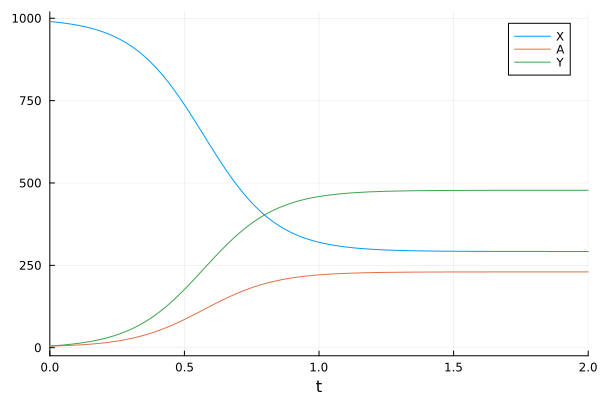

In [14]:
# results are tested the same as the Anylogic model
prob_XAY = ODEProblem(vectorfield(XAY_model_rewritten),u0,(0.0,2.0),p);
sol = solve(prob_XAY,Tsit5(),abstol=1e-8);
plot(sol)

In [15]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")